In [1]:
%matplotlib inline
import pandas as pd
import sys
import scipy as sp
import numpy as np
import datetime
import seaborn as sns
import plotly
import matplotlib.pyplot as plt

In [2]:
#import ML models

from sklearn.preprocessing import StandardScaler
from sklearn import cross_validation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

In [3]:
from IPython.core.display import HTML

# Feature Engineering

In [4]:
#imports the raw data in chunks. SQL export could not accomodate one CSV dump

USMTO1 = pd.DataFrame.from_csv(r'C:\Users\bcroarkin\Documents\AMT\Education\Springboard\Data\USMTO1.csv', index_col = False)
USMTO2 = pd.DataFrame.from_csv(r'C:\Users\bcroarkin\Documents\AMT\Education\Springboard\Data\USMTO2.csv', index_col = False)
USMTO3 = pd.DataFrame.from_csv(r'C:\Users\bcroarkin\Documents\AMT\Education\Springboard\Data\USMTO3.csv', index_col = False)
USMTO4 = pd.DataFrame.from_csv(r'C:\Users\bcroarkin\Documents\AMT\Education\Springboard\Data\USMTO4.csv', index_col = False)
USMTO5 = pd.DataFrame.from_csv(r'C:\Users\bcroarkin\Documents\AMT\Education\Springboard\Data\USMTO5.csv', index_col = False)

In [5]:
#imports raw data for S&P 500 values and Industrial Production

SP_500 = pd.DataFrame.from_csv(r'C:\Users\bcroarkin\Documents\AMT\Education\Springboard\Data\SP_500.csv', index_col = False)

In [6]:
USMTO_WHOLE = USMTO1.append(USMTO2).append(USMTO3).append(USMTO4).append(USMTO5)

In [7]:
#merges external data with USMTO data

USMTO_WHOLE = USMTO_WHOLE.merge(SP_500, how='inner', on = ['EntryMonth', 'EntryYear'])

In [8]:
#format order date to datetime to prepare for analysis

USMTO_WHOLE['OrderDateFormatted'] = pd.to_datetime(USMTO_WHOLE.OrderDate)

In [9]:
#format changed date to datetime to prepare for analysis

USMTO_WHOLE['ChangedDateFormatted'] = pd.to_datetime(USMTO_WHOLE.ChangedDate)

In [10]:
#format submit date to datetime to prepare for analysis

USMTO_WHOLE['SubmitDateFormatted'] = pd.to_datetime(USMTO_WHOLE.SubmitDate.fillna(''))

In [11]:
#more formatting to get Order Date at End of Month

USMTO_WHOLE['hyphen'] = "-"

USMTO_WHOLE['OrderDateEOM'] = (USMTO_WHOLE.EntryYear.astype(str)) + (USMTO_WHOLE.hyphen) + (USMTO_WHOLE.EntryMonth.astype(str)) + (USMTO_WHOLE.hyphen) + (USMTO_WHOLE.OrderDateFormatted.dt.days_in_month.astype(str))

In [12]:
#format OrderDateEOM to datetime

USMTO_WHOLE['OrderDateEOM'] = pd.to_datetime(USMTO_WHOLE['OrderDateEOM'])

In [13]:
#create column DaysLate which indicates how many days late the order was submitted

USMTO_WHOLE['DaysLate'] = (USMTO_WHOLE['SubmitDateFormatted'] - USMTO_WHOLE['OrderDateEOM']).dt.days - 10

In [14]:
#fill all NaN with "0" -> count=141

USMTO_WHOLE['DaysLate'] = USMTO_WHOLE['DaysLate'].fillna('0')

In [15]:
#cast DaysLate and TotalSale as float64

USMTO_WHOLE['DaysLate'] = pd.to_numeric(USMTO_WHOLE['DaysLate'])
USMTO_WHOLE['TotalSale'] = (USMTO_WHOLE['TotalSale'].replace( '[\$,)]','', regex=True )
               .replace( '[(]','-',   regex=True ).astype(float))

In [16]:
#drop un-needed columns

USMTO_WHOLE = USMTO_WHOLE.drop('SubmitDate', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('OrderDate', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('ChangedDate', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('IsCancel', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('CancelOrderID', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('hyphen', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('IsMatch', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('IsIgnore', axis=1)

In [17]:
#creates columns IsEmailOne, IsEmailTwo, IsCall indicating when reminders are made for a member to submit

USMTO_WHOLE['IsEmailOne'] = USMTO_WHOLE['DaysLate'] >= 1
USMTO_WHOLE.IsEmailOne = USMTO_WHOLE.IsEmailOne.astype('int')       

USMTO_WHOLE['IsEmailTwo'] = USMTO_WHOLE['DaysLate'] >= 5
USMTO_WHOLE.IsEmailTwo = USMTO_WHOLE.IsEmailTwo.astype('int')    

USMTO_WHOLE['IsCall'] = USMTO_WHOLE['DaysLate'] >= 10
USMTO_WHOLE.IsCall = USMTO_WHOLE.IsCall.astype('int')

USMTO_WHOLE['IsBackfill'] = USMTO_WHOLE['DaysLate'] >= 90
USMTO_WHOLE.IsBackfill = USMTO_WHOLE.IsBackfill.astype('int')

USMTO_WHOLE.to_csv('../Data/Intermediate.csv')

#caches the data

In [18]:
#import from cache to save time

USMTO_WHOLE = pd.DataFrame.from_csv('../Data/Intermediate.csv', index_col = False)

In [19]:
USMTO_WHOLE['SaleIndex'] = USMTO_WHOLE['TotalSale']*100/151158.9

# Exploratory Data Analysis

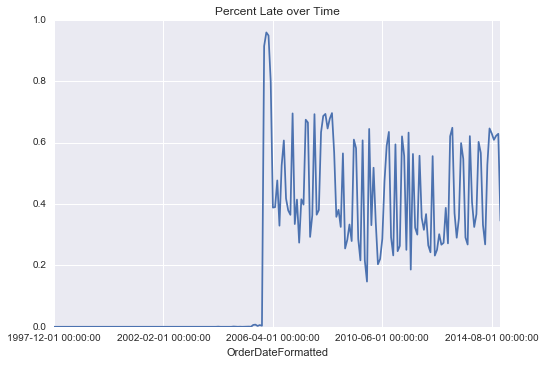

In [20]:
#shows the need to truncate data set

USMTO_WHOLE.groupby(['OrderDateFormatted'])['IsEmailOne'].mean().plot(kind = 'line', title = 'Percent Late over Time')

In [21]:
#tosses the former half of data which may not be relevant

USMTO_WHOLE = USMTO_WHOLE[(USMTO_WHOLE.OrderDateFormatted >= '2006-05-01')]

In [22]:
USMTO_WHOLE.columns

Index([u'Unnamed: 0', u'OrderID', u'AAID', u'NAICSID', u'CustomerZipCode',
       u'ShippingCountryID', u'ShippingZipCode', u'Units', u'TotalSale',
       u'CreatedBy', u'CreateDate', u'ChangedBy', u'IsSubmitted',
       u'TopCategoryName', u'SubCategory', u'SubCategoryName', u'Description',
       u'MachineCode', u'EntryMonth', u'EntryYear', u'Date', u'Close', u'IP',
       u'OrderDateFormatted', u'ChangedDateFormatted', u'SubmitDateFormatted',
       u'OrderDateEOM', u'DaysLate', u'IsEmailOne', u'IsEmailTwo', u'IsCall',
       u'IsBackfill', u'SaleIndex'],
      dtype='object')

In [23]:
#create two new tables, one without outliers (outside 2 stdev), and one without backfillers (defined as submitted later than 30 days - per company definition)

USMTO_NO_SUBMIT_OUTLIERS = USMTO_WHOLE[np.abs(USMTO_WHOLE.DaysLate-USMTO_WHOLE.DaysLate.mean())<=(2*USMTO_WHOLE.DaysLate.std())] 
USMTO_NO_SUBMIT_BACKFILL = USMTO_WHOLE[USMTO_WHOLE.DaysLate <= 30]

#source: http://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-dataframe

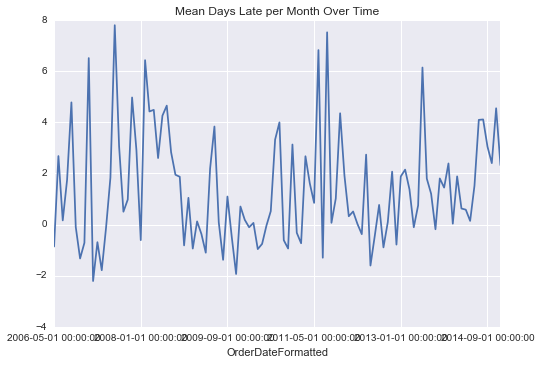

In [24]:
#Plots days late in a time series to see changes over time

USMTO_NO_SUBMIT_BACKFILL.groupby(['OrderDateFormatted'])['DaysLate'].mean().plot(kind = 'line', title = 'Mean Days Late per Month Over Time')

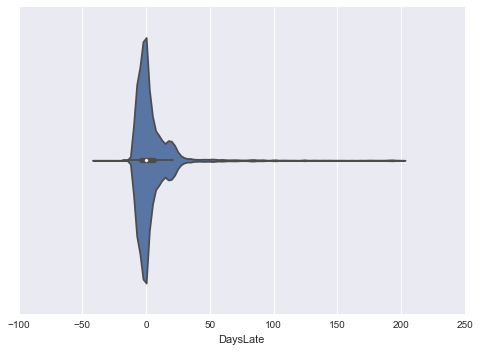

In [25]:
#plots distribution of days late - shows problem is not "endemic" but most rather participants are OK at submitting

sns.violinplot(USMTO_NO_SUBMIT_OUTLIERS.DaysLate, title = 'Distribution of Days Late, 1997 to present')

In [26]:
#Creates table that groups by AAID and OrderDateFormatted

AAID_BY_MONTH = USMTO_WHOLE.groupby(['AAID','OrderDateFormatted'])['DaysLate','TotalSale','IsEmailOne', 'IsEmailTwo', 'IsCall', 'IsBackfill','Close','IP'].mean()
AAID_BY_MONTH.reset_index(level=1, inplace=True)
AAID_BY_MONTH.reset_index(level=1, inplace=True)
AAID_BY_MONTH_2 = USMTO_WHOLE.groupby(['AAID','OrderDateFormatted'])['Units','TotalSale'].sum()
AAID_BY_MONTH_2.reset_index(level=1, inplace=True)
AAID_BY_MONTH_2.reset_index(level=1, inplace=True)
AAID_BY_MONTH = AAID_BY_MONTH.merge(AAID_BY_MONTH_2, how = 'inner', on = ['AAID','OrderDateFormatted'])
AAID_BY_MONTH['TotalSaleAvg'] = AAID_BY_MONTH['TotalSale_x']
AAID_BY_MONTH['TotalSale'] = AAID_BY_MONTH['TotalSale_y']
AAID_BY_MONTH = AAID_BY_MONTH.drop('TotalSale_x', axis = 1)
AAID_BY_MONTH = AAID_BY_MONTH.drop('TotalSale_y', axis = 1)
AAID_BY_MONTH.head()

,AAID,OrderDateFormatted,DaysLate,IsEmailOne,IsEmailTwo,IsCall,IsBackfill,Close,IP,Units,TotalSaleAvg,TotalSale
0,123,2007-12-01 00:00:00,522.0,1,1,1,1,1468.359985,105.7256,13,18461.538462,240000.0
1,123,2010-10-01 00:00:00,673.0,1,1,1,1,1183.260010,95.6362,2,100000.000000,200000.0
2,100005,2006-05-01 00:00:00,-5.0,0,0,0,0,1270.089966,102.1531,7,131438.714286,920071.0
3,100005,2006-06-01 00:00:00,1.0,1,0,0,0,1270.199951,102.5220,2,153945.500000,307891.0
4,100005,2006-07-01 00:00:00,-8.0,0,0,0,0,1276.660034,102.5057,11,57971.090909,637682.0


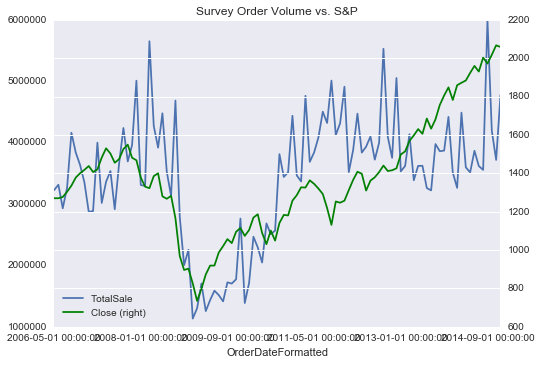

In [27]:
#shows similarity between survey orders and S&P

AAID_BY_MONTH.groupby(['OrderDateFormatted'])['TotalSale'].mean().plot(kind = 'line', legend ='true', title = 'Survey Order Volume vs. S&P')
AAID_BY_MONTH.groupby(['OrderDateFormatted'])['Close'].mean().plot(kind = 'line', secondary_y=True, legend = 'true', style= 'g')

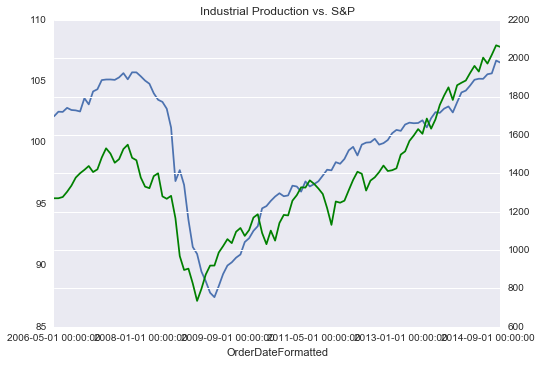

In [28]:
#shows similarity between IP and S&P

AAID_BY_MONTH.groupby(['OrderDateFormatted'])['IP'].mean().plot(kind = 'line', title = 'Industrial Production vs. S&P')
AAID_BY_MONTH.groupby(['OrderDateFormatted'])['Close'].mean().plot(kind = 'line', secondary_y=True, style= 'g')

In [29]:
#creates new table without backfillers (defined as submitted later than 30 days - per company definition)

AAID_BY_MONTH_NO_BACKFILL = AAID_BY_MONTH[AAID_BY_MONTH.DaysLate <= 30]

In [30]:
#exports AAID_BY_MONTH_NO_BACKFILL late by aaid for further analysis

AAID_BY_MONTH_NO_BACKFILL.to_csv('../Data/result.csv',sep = ',')

In [36]:
#imports tables to work on, updated with additional fields

AAID_BY_MONTH_NO_BACKFILL = pd.DataFrame.from_csv('../Data/result.csv', index_col = False)
AAID_BY_MONTH_NO_BACKFILL = AAID_BY_MONTH_NO_BACKFILL.fillna(value = 0)

In [37]:
#exports days late by aaid for further analysis internally

b = AAID_BY_MONTH_NO_BACKFILL.groupby(['AAID'])['DaysLate'].mean()
c = pd.DataFrame(b)
c.to_csv('../Data/DaysLateByAAID.csv',sep = ',')

In [38]:
#shows columns of table we are about to work with

AAID_BY_MONTH_NO_BACKFILL.columns

Index([u'Unnamed: 0', u'AAID', u'OrderDateFormatted', u'DaysLate',
       u'IsEmailOne', u'IsEmailTwo', u'IsCall', u'IsBackfill', u'Close', u'IP',
       u'Units', u'TotalSaleAvg', u'TotalSale', u'UnitsLast', u'IsCallLast',
       u'TotalSaleAvgLast', u'TotalSaleLastThree', u'DaysLateLastThree',
       u'DaysLateLast'],
      dtype='object')

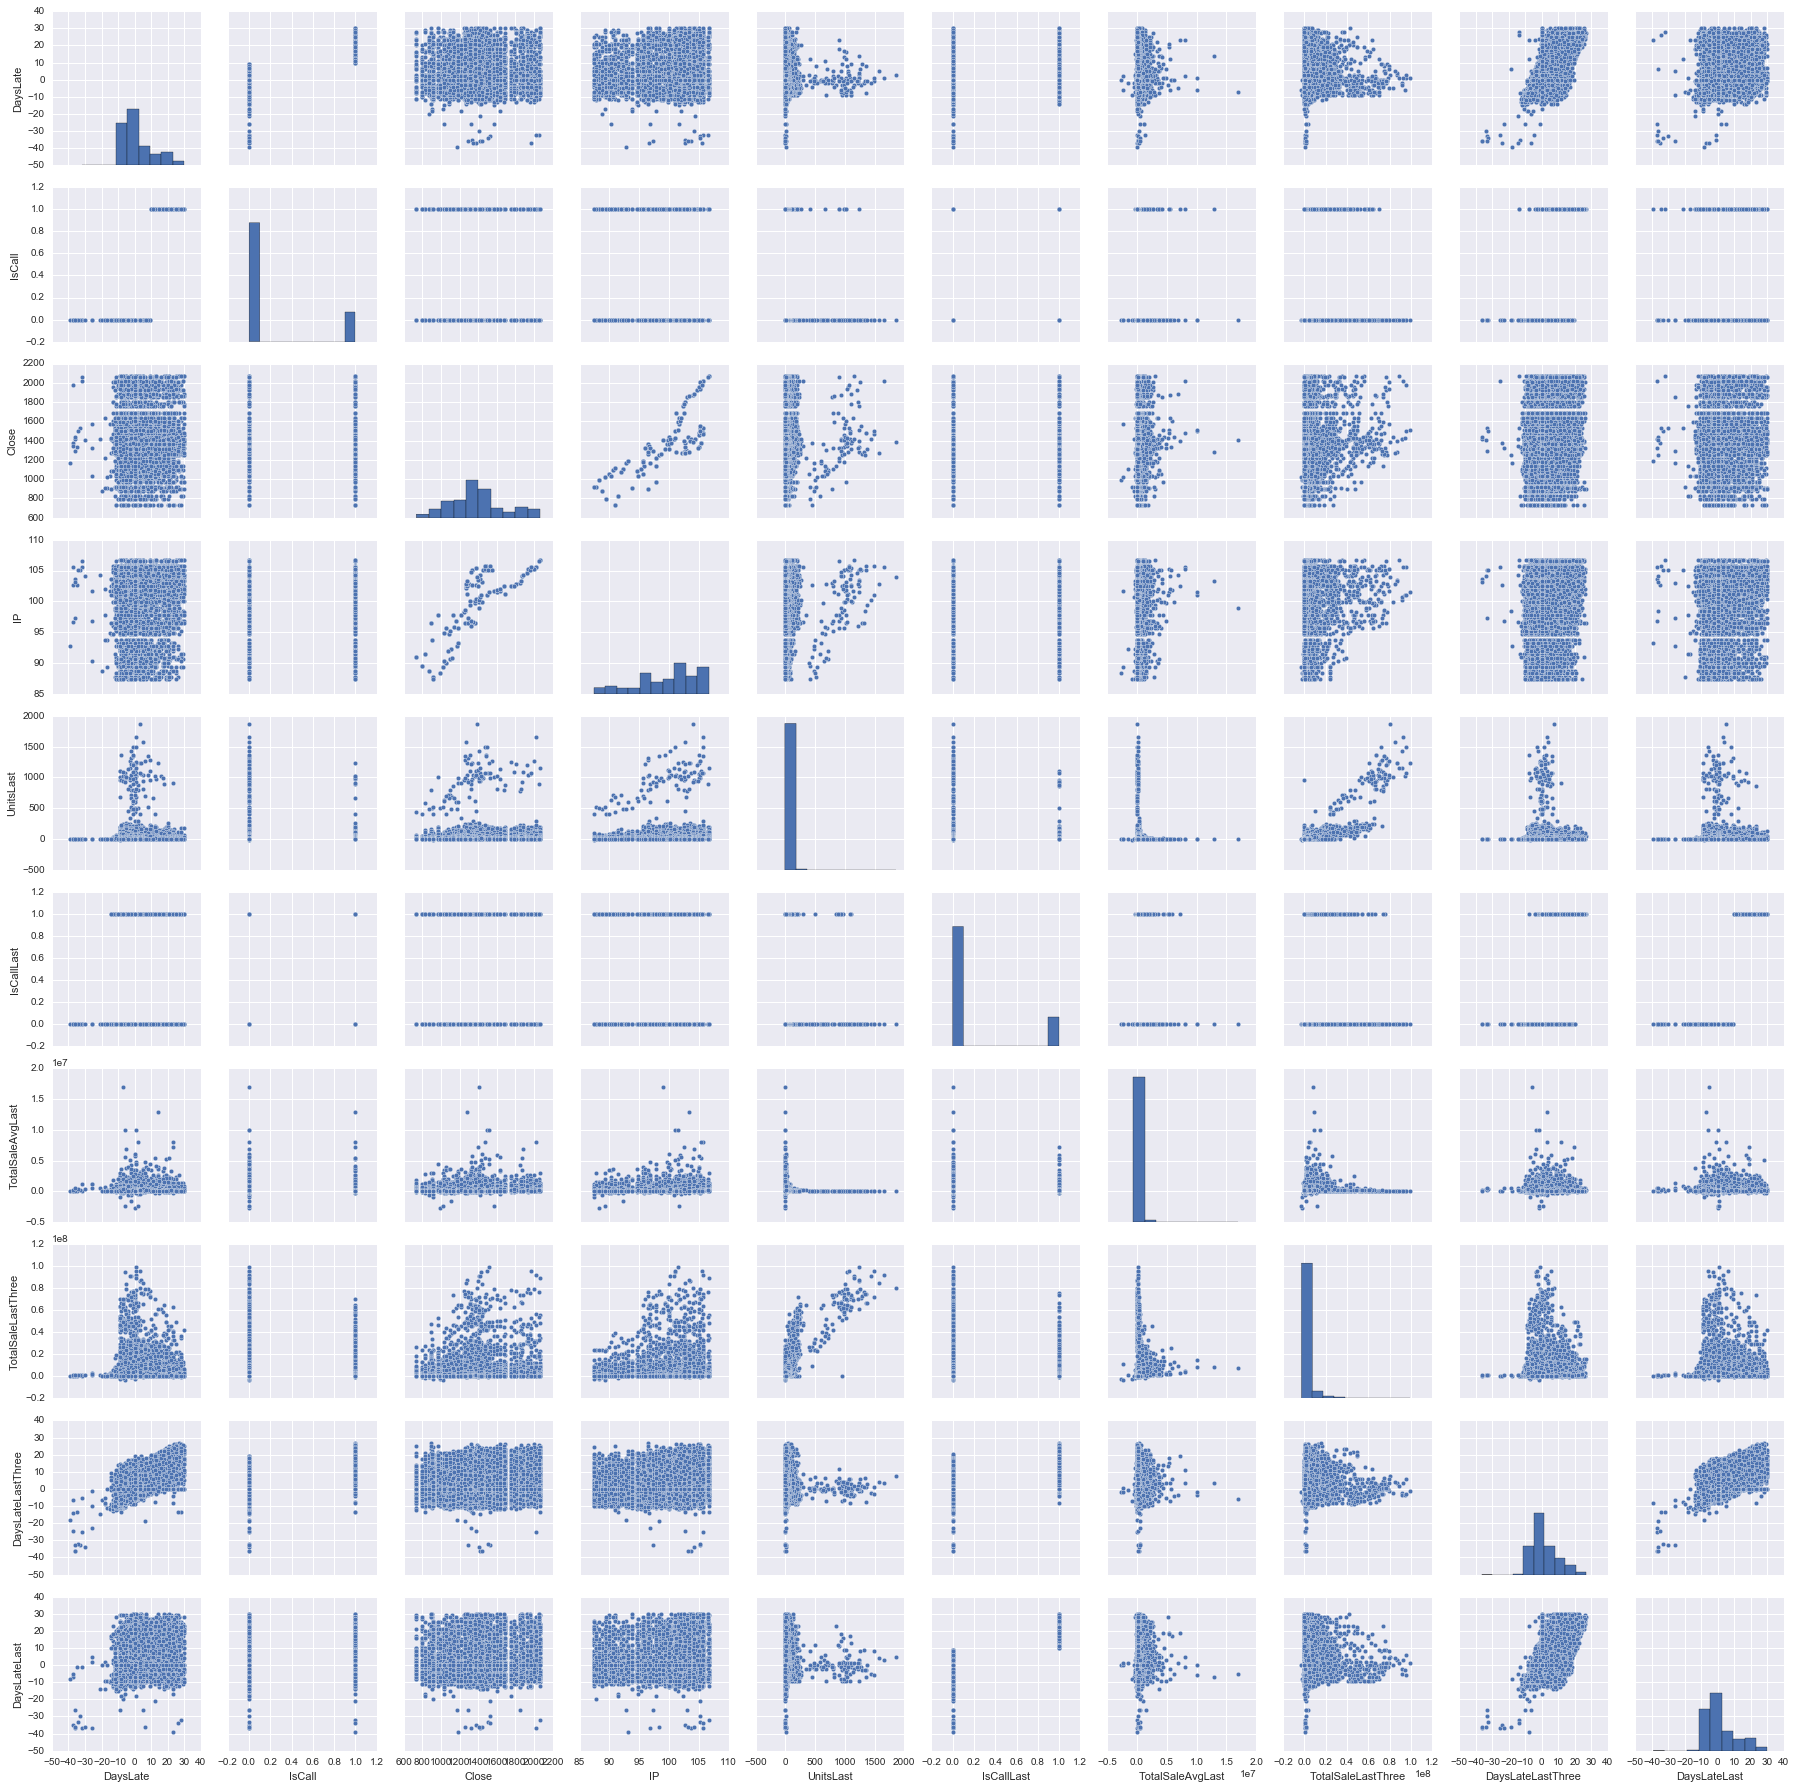

In [39]:
#scatter matrix identifying key features and their relationships - target excluded

PAIRPLOT2 = AAID_BY_MONTH_NO_BACKFILL
PAIRPLOT2 = PAIRPLOT2.drop('Unnamed: 0',axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('AAID', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('OrderDateFormatted', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsEmailOne', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsEmailTwo', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsBackfill', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('TotalSaleAvg', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('Units', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('TotalSale', axis = 1)

sns.pairplot(PAIRPLOT2)

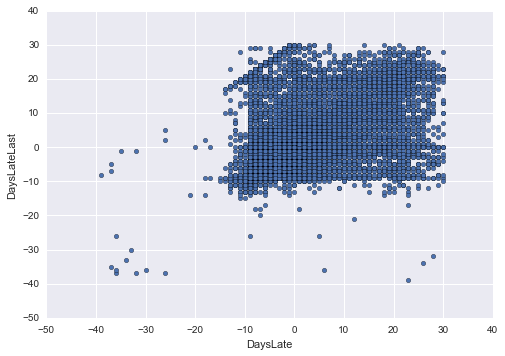

In [40]:
#DaysLate Last vs Days Late

AAID_BY_MONTH_NO_BACKFILL.plot.scatter('DaysLate','DaysLateLast')

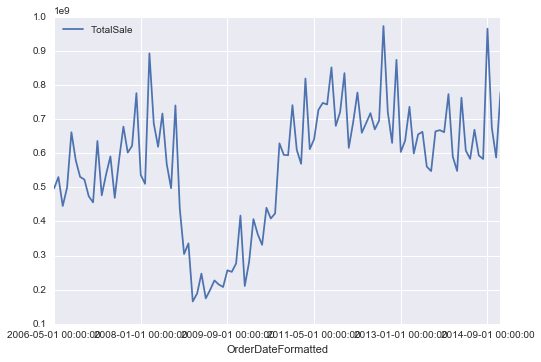

In [41]:
#average sales over time

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).sum()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='TotalSale')

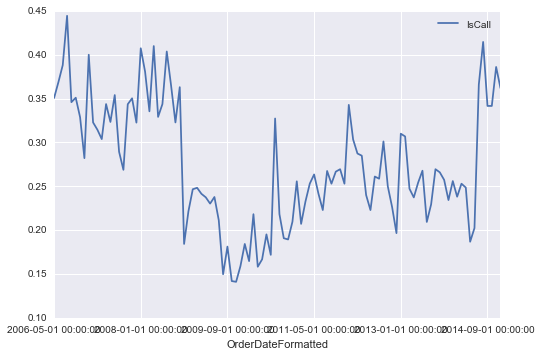

In [42]:
#percentage of company by month who needed to be called

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).mean()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='IsCall')

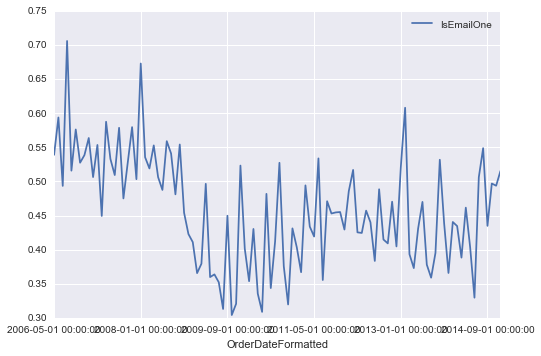

In [43]:
#percentage of company by month who needed to have first email sent

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).mean()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='IsEmailOne')

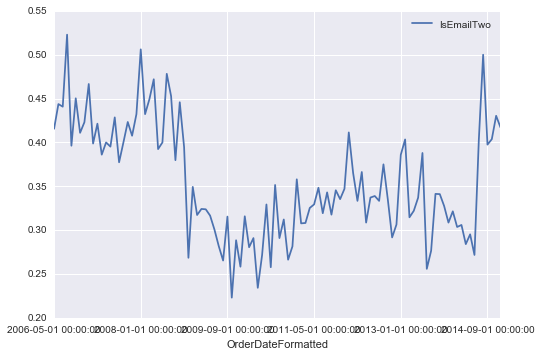

In [44]:
#percentage of company by month who needed to have second email sent

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).mean()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='IsEmailTwo')

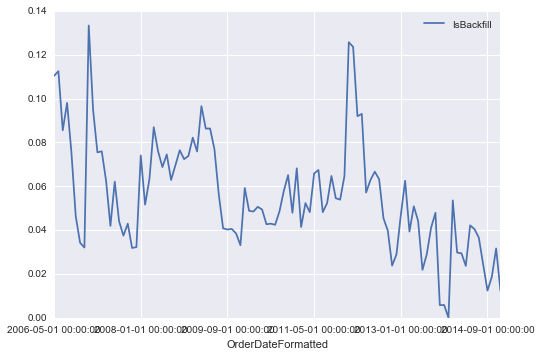

In [45]:
#percentage of company by month who backfilled

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).mean()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='IsBackfill')

In [46]:
#shows columns we are working with in new dataset

PAIRPLOT2.columns

Index([u'DaysLate', u'IsCall', u'Close', u'IP', u'UnitsLast', u'IsCallLast',
       u'TotalSaleAvgLast', u'TotalSaleLastThree', u'DaysLateLastThree',
       u'DaysLateLast'],
      dtype='object')

In [47]:
#prep for correlation matrix - target included. also the dataframe for machine learning algorithms

PAIRPLOT2 = AAID_BY_MONTH_NO_BACKFILL
PAIRPLOT2 = PAIRPLOT2.drop('AAID', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('OrderDateFormatted', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsEmailOne', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsEmailTwo', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsBackfill', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('DaysLate', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('DaysLateLast', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('TotalSaleAvg', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('Units', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('TotalSale', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('Unnamed: 0', axis = 1)

corr2 = PAIRPLOT2.corr(method = 'pearson')

In [48]:
#Class Distribution

AAID_BY_MONTH_NO_BACKFILL.groupby('IsCall').size()

IsCall
0    12321
1     3083
dtype: int64

In [49]:
#Skew of Attributes

PAIRPLOT2.skew()

IsCall                 1.499031
Close                  0.381720
IP                    -0.711474
UnitsLast             11.744413
IsCallLast             1.546985
TotalSaleAvgLast      12.275434
TotalSaleLastThree     5.938483
DaysLateLastThree      0.842505
dtype: float64

In [50]:
#correlation matrix

PAIRPLOT2.corr()

,IsCall,Close,IP,UnitsLast,IsCallLast,TotalSaleAvgLast,TotalSaleLastThree,DaysLateLastThree
IsCall,1.000000,0.078092,0.119986,-0.024218,0.426469,0.033952,-0.004061,0.676785
Close,0.078092,1.000000,0.790527,0.036178,0.066909,0.029737,0.068624,0.087433
IP,0.119986,0.790527,1.000000,0.047017,0.105023,0.030048,0.080664,0.133233
UnitsLast,-0.024218,0.036178,0.047017,1.000000,-0.018719,-0.053599,0.789088,0.000474
IsCallLast,0.426469,0.066909,0.105023,-0.018719,1.000000,0.034827,0.001919,0.687614
TotalSaleAvgLast,0.033952,0.029737,0.030048,-0.053599,0.034827,1.000000,0.110008,0.050857
TotalSaleLastThree,-0.004061,0.068624,0.080664,0.789088,0.001919,0.110008,1.000000,0.027028
DaysLateLastThree,0.676785,0.087433,0.133233,0.000474,0.687614,0.050857,0.027028,1.000000


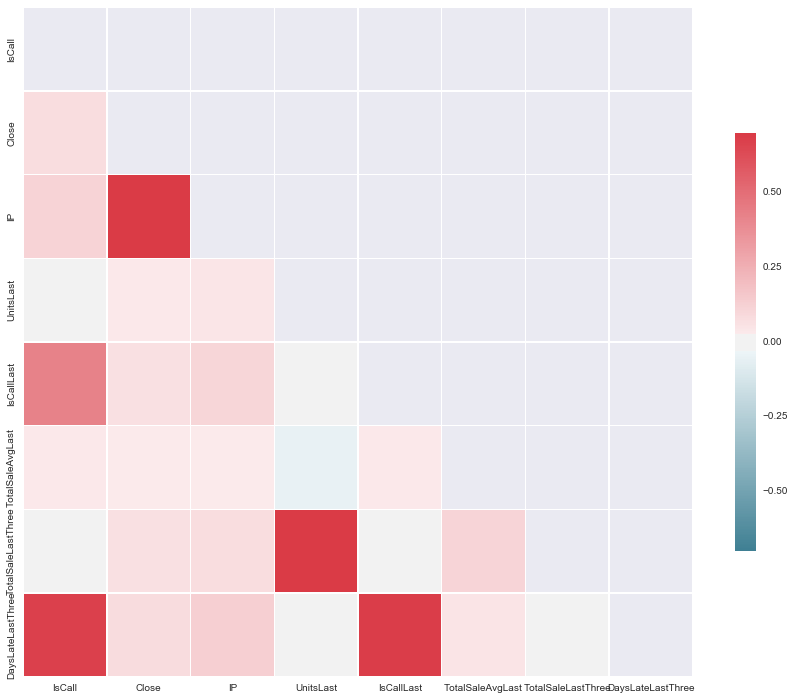

In [51]:
#Correlation Matrix Plot
import matplotlib.pyplot as plt

# Generate a mask for the upper triangle
mask = np.zeros_like(corr2, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15,15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr2, mask=mask, cmap=cmap, vmax=.7,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

In [52]:
#shows key characteristics of the dataset we will run through ML models

PAIRPLOT2.describe()

,IsCall,Close,IP,UnitsLast,IsCallLast,TotalSaleAvgLast,TotalSaleLastThree,DaysLateLastThree
count,15404.000000,15404.000000,15404.000000,15404.000000,15404.000000,1.540400e+04,1.540400e+04,15404.000000
mean,0.200143,1387.566108,99.669018,22.860231,0.194105,2.327467e+05,3.465856e+06,1.531751
std,0.400120,294.775988,4.946942,85.524648,0.395523,4.209686e+05,7.752121e+06,7.536289
min,0.000000,735.090027,87.412500,-7.000000,0.000000,-2.639510e+06,-2.828082e+06,-36.300000
25%,0.000000,1186.689941,96.433700,3.000000,0.000000,7.234793e+04,5.542395e+05,-4.000000
50%,0.000000,1365.680054,101.038200,8.000000,0.000000,1.369645e+05,1.351180e+06,0.000000
75%,0.000000,1526.750000,103.494100,19.000000,0.000000,2.593512e+05,3.150072e+06,5.700000
max,1.000000,2067.560059,106.686800,1867.000000,1.000000,1.700000e+07,9.903093e+07,26.700000


# Feature Selection

In [53]:
# Feature Importance with Extra Trees Classifier

from sklearn.ensemble import ExtraTreesClassifier
array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]

# feature importance - highest to lowest based on coefficient

model = ExtraTreesClassifier()
model.fit(X, Y)
print(model.feature_importances_)

[ 0.05830617  0.06104053  0.09185883  0.14230596  0.10371531  0.09598601
  0.44678718]


In [54]:
# Feature Extraction with RFE 

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# load data

array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
# feature extraction
model = LogisticRegression()
rfe = RFE(model, 4)
fit = rfe.fit(X, Y)
print("Num Features: " , fit.n_features_)
print("Selected Features: " , fit.support_)
print("Feature Ranking: " , fit.ranking_)

('Num Features: ', 4)
('Selected Features: ', array([False,  True,  True,  True, False, False,  True], dtype=bool))
('Feature Ranking: ', array([2, 1, 1, 1, 3, 4, 1]))


In [55]:
#tags just the features for later use

a = pd.DataFrame({'Close':X[:,0],'IP':X[:,1],'UnitsLast':X[:,2],'IsCallLast':X[:,3],'TotalSaleAvgLast':X[:,4],'TotalSaleLastThree':X[:,5],'DaysLateLastThree':X[:,6]}).head()

In [56]:
#test different types of models without optimizing k and validation size - we see cart without any modifications is initially the best

array = PAIRPLOT2.values
X = array[:,1:14].astype(float)
Y = array[:,0]
validation_size = 0.33
seed = 7
X_train, X_validation, Y_train, Y_validation = cross_validation.train_test_split(X, Y,
test_size=validation_size, random_state=seed)
num_folds = 5
num_instances = len(X_train)
seed = 7
scoring = 'recall'
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('KNNWeighted', KNeighborsClassifier(weights='distance')))
models.append(('CART', DecisionTreeClassifier()))
models.append(('CART Max Depth 10', DecisionTreeClassifier(max_depth= 10)))
models.append(('NB', GaussianNB()))
results = []
names = []
for name, model in models:
    kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
    cv_results = cross_validation.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = (name, cv_results.mean(),cv_results.std())
    print(msg)

('LR', 0.0, 0.0)
('LDA', 0.67548985818166085, 0.024707664260767797)
('KNN', 0.088575913682633928, 0.0090990084725347583)
('KNNWeighted', 0.13076248776658866, 0.014097851002096788)
('CART', 0.6370448333889317, 0.02762203079515943)
('CART Max Depth 10', 0.62559257490336906, 0.02900184238414736)
('NB', 0.026854596084459857, 0.0079540012496751474)


In [75]:
#test different types of models with optimal k and validation size - we see cart with max depth is now the best algorithm

array = PAIRPLOT2.values
X = array[:,1:14].astype(float)
Y = array[:,0]
validation_size = 0.2
seed = 7
X_train, X_validation, Y_train, Y_validation = cross_validation.train_test_split(X, Y,
test_size=validation_size, random_state=seed)
num_folds = 10
num_instances = len(X_train)
seed = 7
scoring = 'recall'
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('KNNWeighted', KNeighborsClassifier(weights='distance')))
models.append(('CART', DecisionTreeClassifier()))
models.append(('CART Max Depth 10', DecisionTreeClassifier(max_depth= 10)))
models.append(('NB', GaussianNB()))
results = []
names = []
for name, model in models:
    kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
    cv_results = cross_validation.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = (name, cv_results.mean(),cv_results.std())
    print(msg)

('LR', 0.00042372881355932202, 0.001271186440677966)
('KNN', 0.088806013717528193, 0.018891092111885915)
('KNNWeighted', 0.13128411205041574, 0.016709752322155894)
('CART', 0.64132334508257682, 0.021284771183516394)
('CART Max Depth 10', 0.63908748096194201, 0.041336752623466512)
('NB', 0.027720870909742634, 0.010358088082731847)


In [58]:
#generate table to determine optimal max depth

array = PAIRPLOT2.values
X = array[:,1:14].astype(float)
Y = array[:,0]
validation_size = 0.2
seed = 7
X_train, X_validation, Y_train, Y_validation = cross_validation.train_test_split(X, Y,
test_size=validation_size, random_state=seed)
num_folds = 10
num_instances = len(X_train)
seed = 7
depth = 1
scoring = 'recall'
models = []
results = []
names = []
scores = [0]
table = pd.DataFrame(columns = range(1))
for depth in range(1,31):
        models.append((('CART max depth:', depth), DecisionTreeClassifier(max_depth = depth)))
for name, model in models:
        kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
        cv_results = cross_validation.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        scores.append(cv_results.mean())
        msg = (name, cv_results.mean(),cv_results.std())
        print(msg)
        
table = table.append(scores)

(('CART max depth:', 1), 0.70385063904606626, 0.03978623867312877)
(('CART max depth:', 2), 0.57195323768208051, 0.096468390114926)
(('CART max depth:', 3), 0.60582698160145765, 0.060510125476912979)
(('CART max depth:', 4), 0.61394280624456798, 0.033960947965316894)
(('CART max depth:', 5), 0.61277310108882177, 0.047014878042240429)
(('CART max depth:', 6), 0.66177798547940114, 0.051034135989616154)
(('CART max depth:', 7), 0.66772786795817651, 0.042882391030549576)
(('CART max depth:', 8), 0.65661309679843638, 0.045483107018149872)
(('CART max depth:', 9), 0.63860413105146319, 0.042825482032556136)
(('CART max depth:', 10), 0.6396023598919589, 0.040013629494153373)
(('CART max depth:', 11), 0.64261143811804766, 0.035694710666694072)
(('CART max depth:', 12), 0.64075312710491106, 0.037103051183472589)
(('CART max depth:', 13), 0.64166047139510418, 0.030064131586742454)
(('CART max depth:', 14), 0.64283684906040439, 0.024252099600804169)
(('CART max depth:', 15), 0.63669172484136416, 0

In [59]:
#generate table to determine optimal leaf size

array = PAIRPLOT2.values
X = array[:,1:14].astype(float)
Y = array[:,0]
validation_size = 0.2
seed = 7
X_train, X_validation, Y_train, Y_validation = cross_validation.train_test_split(X, Y,
test_size=validation_size, random_state=seed)
num_folds = 10
num_instances = len(X_train)
seed = 7
depth = 1
scoring = 'recall'
models = []
results_leaf = []
names = []
scores = [0]
leaf_size_table = pd.DataFrame(columns = range(1))
for leaf in range(1,31):
        models.append((('CART min leaf size:', leaf*200), DecisionTreeClassifier(min_samples_leaf= leaf*200)))
for name, model in models:
        kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
        cv_results = cross_validation.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
        results_leaf.append(cv_results)
        names.append(name)
        scores.append(cv_results.mean())
        msg = (name, cv_results.mean(),cv_results.std())
        print(msg)
        
leaf_size_table = leaf_size_table.append(scores)

(('CART min leaf size:', 200), 0.65336175360077497, 0.038785535659835522)
(('CART min leaf size:', 400), 0.60282671008367328, 0.060392737606825377)
(('CART min leaf size:', 600), 0.58955323768208046, 0.096330869013812603)
(('CART min leaf size:', 800), 0.57195323768208051, 0.096468390114926)
(('CART min leaf size:', 1000), 0.57195323768208051, 0.096468390114926)
(('CART min leaf size:', 1200), 0.70385063904606626, 0.03978623867312877)
(('CART min leaf size:', 1400), 0.70385063904606626, 0.03978623867312877)
(('CART min leaf size:', 1600), 0.70385063904606626, 0.03978623867312877)
(('CART min leaf size:', 1800), 0.70385063904606626, 0.03978623867312877)
(('CART min leaf size:', 2000), 0.70385063904606626, 0.03978623867312877)
(('CART min leaf size:', 2200), 0.74204674967269835, 0.015932974742380691)
(('CART min leaf size:', 2400), 0.75405688130624815, 0.013910882399021995)
(('CART min leaf size:', 2600), 0.77802594553784687, 0.015785074833109074)
(('CART min leaf size:', 2800), 0.804456

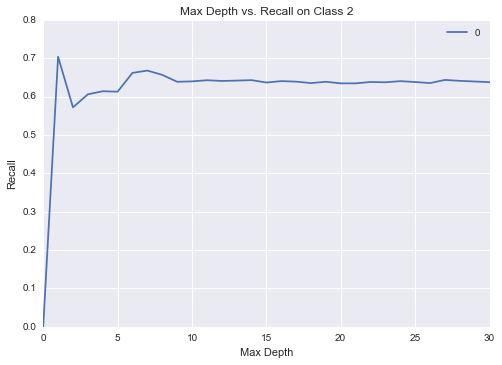

In [60]:
#plot max depth vs recall

depth_plot = table.plot(kind = 'line' ,title = 'Max Depth vs. Recall on Class 2')
depth_plot.set_xlabel("Max Depth")
depth_plot.set_ylabel("Recall")

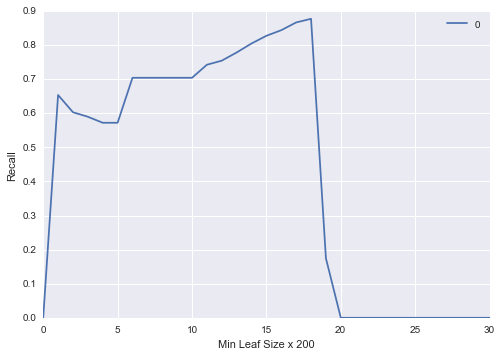

In [61]:
#plot min leaf size vs recall

leaf_plot = leaf_size_table.plot(kind = 'line',label = 'Min Leaf Size vs. Recall on Class 2')
leaf_plot.set_xlabel("Min Leaf Size x 200")
leaf_plot.set_ylabel("Recall")

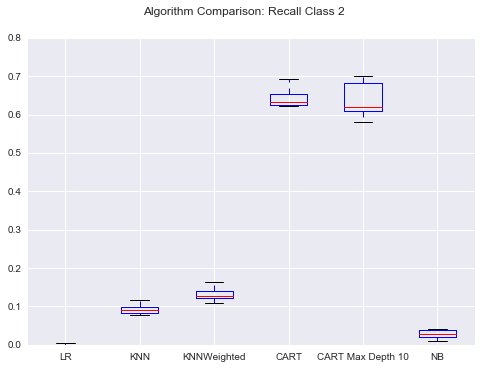

In [76]:
#distribution of models, accuracy and std dev

fig = plt.figure()
fig.suptitle('Algorithm Comparison: Recall Class 2')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [63]:
#exports decision tree for viewing - we see that it's massive and indicates overfitting

from sklearn import tree

clf = tree.ExtraTreeClassifier(max_depth=5)
clf = clf.fit(X_train, Y_train)
tree.export_graphviz(clf, out_file='decisiontree.dot',feature_names = a.columns)  

In [64]:
#exports decision tree for viewing - we see that it's massive and indicates overfitting

from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, Y_train)
tree.export_graphviz(clf, out_file='decisiontreebetter.dot',feature_names = a.columns)   

In [65]:
#classification report with kNN

from sklearn.metrics import classification_report

array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
test_size = 0.33
seed = 7
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y,
test_size=test_size, random_state=seed)
model = KNeighborsClassifier()
model.fit(X_train, Y_train)
predicted = model.predict(X_test)
report = classification_report(Y_test, predicted)
print(report)

             precision    recall  f1-score   support

        0.0       0.79      0.93      0.86      4009
        1.0       0.27      0.09      0.14      1075

avg / total       0.68      0.76      0.71      5084



In [66]:
#classification report with kNN adjusted k

from sklearn.metrics import classification_report

array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
test_size = 0.33
seed = 7
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y,
test_size=test_size, random_state=seed)
model = KNeighborsClassifier(n_neighbors = 1)
model.fit(X_train, Y_train)
predicted = model.predict(X_test)
report = classification_report(Y_test, predicted)
print(report)

             precision    recall  f1-score   support

        0.0       0.79      0.81      0.80      4009
        1.0       0.23      0.22      0.23      1075

avg / total       0.67      0.68      0.68      5084



In [67]:
#classification report with CART 

from sklearn.metrics import classification_report

array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
test_size = 0.33
seed = 7
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y,
test_size=test_size, random_state=seed)
model = RandomForestClassifier(max_depth = 5)
model.fit(X_train, Y_train)
predicted = model.predict(X_test)
report = classification_report(Y_test, predicted)
print(report)

             precision    recall  f1-score   support

        0.0       0.88      0.97      0.92      4009
        1.0       0.82      0.48      0.61      1075

avg / total       0.86      0.87      0.86      5084



In [68]:
#classification report with CART with max depth of 10

from sklearn.metrics import classification_report

array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
test_size = 0.2
seed = 10
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y,
test_size=test_size, random_state=seed)
model = DecisionTreeClassifier(max_depth = 10)
model.fit(X_train, Y_train)
predicted = model.predict(X_test)
report = classification_report(Y_test, predicted)
print(report)

             precision    recall  f1-score   support

        0.0       0.91      0.94      0.93      2445
        1.0       0.75      0.64      0.69       636

avg / total       0.88      0.88      0.88      3081



In [69]:
#classification report with CART with max depth of 10 and min samples/leaf of 4000

from sklearn.metrics import classification_report

array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
test_size = 0.2
seed = 10
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y,
test_size=test_size, random_state=seed)
model = DecisionTreeClassifier(max_depth = 10, min_samples_leaf=4000)
model.fit(X_train, Y_train)
predicted = model.predict(X_test)
report = classification_report(Y_test, predicted)
print(report)

             precision    recall  f1-score   support

        0.0       0.96      0.79      0.87      2445
        1.0       0.52      0.87      0.65       636

avg / total       0.87      0.81      0.82      3081



In [70]:
#classification report with Logistic Regression

array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
test_size = 0.2
seed = 7
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y,
test_size=test_size, random_state=seed)
model = LogisticRegression()
model.fit(X_train, Y_train)
predicted = model.predict(X_test)
report = classification_report(Y_test, predicted)
print(report)

             precision    recall  f1-score   support

        0.0       0.79      1.00      0.88      2420
        1.0       0.00      0.00      0.00       661

avg / total       0.62      0.79      0.69      3081



In [71]:
#classification report with Naive Bayes

array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
test_size = .2
seed = 7
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y,
test_size=test_size, random_state=seed)
model = GaussianNB()
model.fit(X_train, Y_train)
predicted = model.predict(X_test)
report = classification_report(Y_test, predicted)
print(report)

             precision    recall  f1-score   support

        0.0       0.79      0.98      0.87      2420
        1.0       0.21      0.02      0.04       661

avg / total       0.66      0.77      0.69      3081



In [72]:
# ROC statistic for reference - indicates a "good" model by conventional standards
# source for "good": http://gim.unmc.edu/dxtests/roc3.htm

from sklearn import cross_validation
array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
num_folds = 10
num_instances = len(X)
seed = 7
kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
model = DecisionTreeClassifier(max_depth = 9)
scoring = 'roc_auc'
results = cross_validation.cross_val_score(model, X, Y, cv=kfold, scoring = scoring)
print("AUC: ", results.mean(), "      Std Dev: ", results.std()*100.0)

('AUC: ', 0.91223310893734499, '      Std Dev: ', 1.8409569878709908)


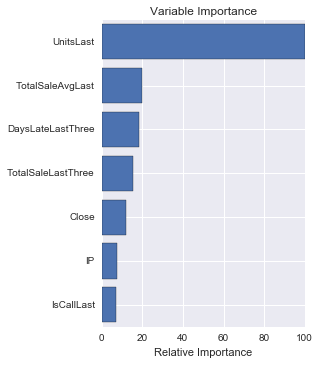

In [73]:
# Plot feature importance

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 1,
          'learning_rate': 0.01, 'loss': 'ls'}

clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, Y_train)

feature_importance = clf.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, a.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()